# Embedit project
- data exploration:
    - Data dimensions after loading: (200000, 56)
    - Target variable is **binary** (containing just 2 values)
    - Almost all numerical features contain unique values (no constants)
    - Few numerical and few categorical features contain a high percentage of NULL values (deal with it efficiently)
    - Data types (1x timestamps, floats, categories as objects, target as int)
    - Data frame doesnt contain any duplicated row (no duplicated rows)
    - No empty columns
    - Columns with null values: 2 columns with 30% of NULL values, 4 columns with 40% of NULL values
    - Distribution of values for the target variable:
    - 0: Count=128222, Percentage=64.11%
    - 1: Count=71778, Percentage=35.89%
    - Dataset is imbalanced (use algorithms and metrics to cover it)

2024-03-26 11:27:40,907 - INFO - Loading data from file: it_data.csv
2024-03-26 11:27:43,056 - INFO - Data dimensions after loading: (200000, 56)
2024-03-26 11:27:43,059 - INFO - Distribution of values for the target variable:
2024-03-26 11:27:43,060 - INFO - 0: Count=128222, Percentage=64.11%
2024-03-26 11:27:43,060 - INFO - 1: Count=71778, Percentage=35.89%
2024-03-26 11:27:43,061 - INFO - Count of columns for each data type: {dtype('float64'): 42, dtype('O'): 11, dtype('int64'): 2, dtype('<M8[ns]'): 1}
2024-03-26 11:27:43,373 - INFO - No duplicate rows found.
2024-03-26 11:27:43,419 - INFO - No columns with all null values found.
2024-03-26 11:27:43,420 - INFO - Total number of rows: 200000
2024-03-26 11:27:43,462 - INFO - Number of rows containing null values: 139376
2024-03-26 11:27:43,515 - INFO - Data dimensions after dropping rows containing NULL values: (60624, 56)
2024-03-26 11:28:02,917 - INFO - Total number of outliers detected: 0
2024-03-26 11:28:02,918 - INFO - Applying o

Evaluation metrics on the test set:
Accuracy: 0.8835
Precision: 0.8396
Recall: 0.7286
F1-score: 0.7802


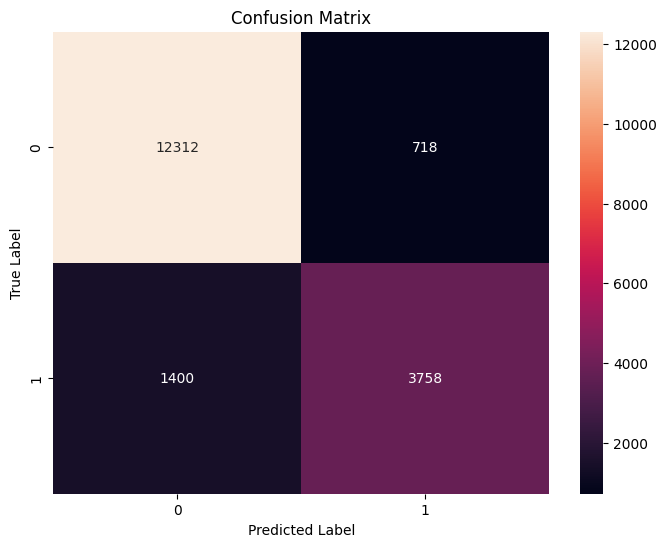

{'accuracy': 0.8835495931383329,
 'precision': 0.8395889186773905,
 'recall': 0.7285769678169833,
 'f1-score': 0.7801536225866722,
 'confusion_matrix': array([[12312,   718],
        [ 1400,  3758]])}

In [19]:
import logging
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import TargetEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



class BinaryClassModel:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        """
        Load CSV data from the specified file path and convert the 'time'
        column to timestamp format. Additionally, check the distribution of
        values for the target variable 'TARGET' and print it via logging.
    
        Returns:
            pandas.DataFrame: DataFrame containing the loaded data.
        """
        logging.info("Loading data from file: %s", self.file_path)
        # low_memory - handling mixed data type columns
        data = pd.read_csv(self.file_path, low_memory=False)
    
        # Convert timeslot_datetime_from from object to timestamp format
        data['TIME'] = pd.to_datetime(data['TIME'])
    
        data = data.sort_values(by=['TIME'])
        logging.info("Data dimensions after loading: %s", data.shape)
    
        return data


    def visualize_target_distribution(self, df, target_column, visualize_target=True):
        """
        Count and visualize the distribution of values for the target variable.
    
        Parameters:
            df (pandas.DataFrame): DataFrame containing the data.
            target_column (str): Name of the target column.
            visualize_target (bool): Whether to visualize the distribution. Default is True.
    
        Returns:
            None
        """
        # Count the occurrences of each value in the target variable
        target_counts = df[target_column].value_counts()

        # Calculate percentages
        total_count = len(df)
        target_percentages = (target_counts / total_count) * 100
    
        if visualize_target:
            # Visualize the distribution using a bar plot
            plt.figure(figsize=(8, 6))
            sns.countplot(data=df, x=target_column)
            plt.title(f'Distribution of {target_column}')
            plt.xlabel(target_column)
            plt.ylabel('Count')
            plt.show()
    
        # Print the count and percentage of each value in the target variable
        logging.info("Distribution of values for the target variable:")
        for value, count, percentage in zip(target_counts.index, target_counts, target_percentages):
            logging.info("%s: Count=%d, Percentage=%.2f%%", value, count, percentage)

    
    def statistics(self, df, describe=True, unique_count=False, missing_count=False, data_types=False):
        """
        Display statistics for a pandas DataFrame including count of unique values, count of missing values,
        and data types of columns.
        
        Parameters:
        - df (DataFrame): The pandas DataFrame for which extended statistics are to be calculated.
        """
        try:
            if describe:
                # Basic statistics for numerical columns
                print("Basic statistics for numerical columns:")
                print(df.describe())
            
            if unique_count:
                # Count of unique values for each column
                print("\nCount of unique values for each column:")
                print(df.nunique())
            
            if missing_count:
                # Count of missing values for each column
                print("\nCount of missing values for each column:")
                print(df.isnull().sum())
            
            if data_types:
                # Data types of columns
                print("\nData types of columns:")
                print(df.dtypes)
        
        except Exception as e:
            print("An error occurred:", e)


    def count_columns_by_datatype(self, df):
        """
        Count the number of columns for each data type in a DataFrame.
        
        Parameters:
        df (pandas.DataFrame): Input DataFrame.
        
        Returns:
        dict: Dictionary containing the count of columns for each data type.
        """
        # Get the data types of columns
        dtypes = df.dtypes
        count_by_datatype = dtypes.value_counts().to_dict()
        
        logging.info("Count of columns for each data type: %s", count_by_datatype)
        
        return count_by_datatype

    
    def find_duplicate_rows(self, df):
        """
        Find duplicate rows in a pandas DataFrame.
        
        Parameters:
        - df (DataFrame): The pandas DataFrame to be checked for duplicate rows.
        
        Returns:
        - DataFrame: The DataFrame with duplicate rows removed.
        """
        try:
            # Check for duplicate rows
            duplicate_rows = df[df.duplicated()]
    
            # If duplicate rows are found
            if not duplicate_rows.empty:
                num_duplicates = len(duplicate_rows)
                total_rows = len(df)
                duplicate_percentage = (num_duplicates / total_rows) * 100
                
                logging.info("Number of duplicate rows found:", num_duplicates)
                logging.info("Percentage of duplicate rows from the total:", duplicate_percentage, "%")
                
                return df
            else:
                logging.info("No duplicate rows found.")
                return df
        except Exception as e:
            print("An error occurred:", e)
            return None


    def null_percentage(self, df, just_nulls=False):
        """
        Calculate and display the percentage of null values for each column in a pandas DataFrame.
        
        Parameters:
        - df (DataFrame): The pandas DataFrame for which null percentages are to be calculated.
        - just_nulls (bool): If True, show only columns with all null values.
        """
        try:
            # Calculate the percentage of null values for each column
            null_percentages = (df.isnull().sum() / len(df)) * 100
            
            if just_nulls:
                # Filter columns with all null values
                null_columns = null_percentages[null_percentages == 100]
                if not null_columns.empty:
                    logging.info("Columns with all null values:")
                    logging.info(null_columns)
                else:
                    logging.info("No columns with all null values found.")
            else:
                # Display the percentage of null values for each column
                logging.info("Percentage of null values for each column:")
                logging.info(null_percentages)
        except Exception as e:
            logging.error("An error occurred: %s - %s", type(e).__name__, e)


    def count_rows_with_null(self, df):
        """
        Calculate the number of rows containing null values in a pandas DataFrame.
        
        Parameters:
        - df (DataFrame): The pandas DataFrame to be checked for null values.
        
        Returns:
        - int: The number of rows containing null values.
        """
        logging.info("Total number of rows: %d", df.shape[0])
        # Calculate the number of rows containing null values
        rows_with_null = df.isnull().any(axis=1).sum()
        logging.info("Number of rows containing null values: %d", rows_with_null)
        return rows_with_null
    
    
    def drop_missing_rows(self, df):
        """
        Drop rows with missing values in a pandas DataFrame.
    
        Parameters:
        df (pandas.DataFrame): Input DataFrame containing missing values.
    
        Returns:
        pandas.DataFrame: DataFrame with missing rows dropped.
        """
        # Drop rows with any missing values
        df.dropna(axis=0, how='any', inplace=True)
        
        # Log the shape of the DataFrame after dropping rows
        logging.info("Data dimensions after dropping rows containing NULL values: %s", df.shape)
    
        return df

    
    def correlation_analysis(self, df):
        """
        Perform correlation analysis for numerical features in a DataFrame.
        Highly correlated features may not provide additional information to the model
        
        Parameters:
            df (pandas.DataFrame): Input DataFrame containing numerical features.
    
        Returns:
            pandas.DataFrame: DataFrame containing the correlation matrix.
        """
        # Select only numerical columns
        numerical_columns = df.select_dtypes(include=[np.number])
    
        # Calculate the correlation matrix
        correlation_matrix = numerical_columns.corr()
    
        # Visualize the correlation matrix as a heatmap
        plt.figure(figsize=(17, 17))
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Correlation Matrix')
        plt.show()
    
        return correlation_matrix


    def detect_and_remove_outliers(self, df, z_thresh=3, visualize=False, apply=False):
        """
        Detect outliers in float numerical columns of the dataset using the Z-score method.
    
        Parameters:
            df (pandas.DataFrame): Input DataFrame.
            threshold (float): Threshold value for outlier detection. Default is 3.
            visualize (bool): Whether to visualize the distribution of data for each column. Default is False.
            apply (bool): Whether to apply outlier removal. Default is False.
    
        Returns:
            pandas.DataFrame: DataFrame containing outlier information for each column.
        """
        def is_outlier(x):
            """
            Returns True if a value is an outlier based on the Z-score threshold.
            """
            if not pd.api.types.is_numeric_dtype(x):
                return False
            return abs(x - x.mean()) > z_thresh * x.std()
        
        # Select float columns and detect outliers
        float_cols = df.select_dtypes(include=[np.float64])
        outlier_indices = []
        for col in float_cols:
            outlier_mask = df[col].apply(is_outlier)
            outlier_indices.extend(df[outlier_mask].index.tolist())
        
        # Combine outlier indices and remove duplicates
        outlier_indices = list(set(outlier_indices))

        # Log the number of total outliers detected
        logging.info(f"Total number of outliers detected: {len(outlier_indices)}")

        # Visualize box plots if visualize is True
        if visualize:
            num_plots = len(float_cols)
            num_cols = min(num_plots, 5)
            num_rows = (num_plots + num_cols - 1) // num_cols

            fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
            axes = axes.flatten()

            for i, col in enumerate(float_cols):
                sns.boxplot(x=df[col], ax=axes[i])
                axes[i].set_title(f'Box plot of {col}')
                axes[i].set_xlabel(col)

            plt.tight_layout()
            plt.show()

        # Apply outlier removal if apply is True
        if apply:
            logging.info("Applying outlier removal...")
            df = df.drop(outlier_indices)
            logging.info("Outlier removal applied. DataFrame dimension after removal: %s", df.shape)
        else:
            logging.info("Applying outlier removal is skipped.")

        return df
    

    def extract_datetime_features(self, df, enable=False):
        """
        Extract datetime features from the timeslot_datetime_from column.

        Parameters:
            data (DataFrame): DataFrame containing the CSV data with 'timeslot_datetime_from' column.
            enable (bool): Flag to enable/disable datetime feature extraction. Default is True.

        Returns:
            DataFrame: DataFrame with extracted datetime features.
        """
        if not enable:
            logging.info("Datetime feature extraction is disabled. Skipping...")
            return df

        else:
            logging.info("Generating new features: day_of_week, month_of_year and season")

            df['day_of_week'] = df['TIME'].dt.day_name()
            df['month_of_year'] = df['TIME'].dt.month_name()
            # df['hour_of_day'] = df['timeslot_datetime_from'].dt.hour
    
            # Define seasons based on months
            month_to_season = {
                1: 'Winter', 2: 'Winter', 3: 'Spring',
                4: 'Spring', 5: 'Spring', 6: 'Summer',
                7: 'Summer', 8: 'Summer', 9: 'Fall',
                10: 'Fall', 11: 'Fall', 12: 'Winter'
            }
            df['season'] = df['TIME'].dt.month.map(month_to_season)
    
            return df
    
        
    def encode_categorical_features(self, df, enc="one_hot"):
        """
        Encode categorical features using either one-hot encoding or target encoding.
        Target encoding captures the relationship between the categorical variable and the target variable, 
            - potentially improving the predictive performance of the model.
    
        Parameters:
            data (DataFrame): DataFrame containing the CSV data.
            enc (str): Encoding method ("one-hot" or "target"). Default is "one-hot".
    
        Returns:
            DataFrame: DataFrame with categorical features encoded.
        """
    
        # Get list of object columns (categorical features)
        cat_columns = df.select_dtypes(include=['object', 'bool']).columns
    
        if enc == "one_hot":
            # Perform one-hot encoding
            data_encoded = pd.get_dummies(df, columns=cat_columns, dtype=int)
            logging.info("Data dimensions after one-hot encoding: %s", data_encoded.shape)
        elif enc == "target":
            # Implement target encoding
            encoder = TargetEncoder()
            data_encoded = df.copy()
            data_encoded[cat_columns] = encoder.fit_transform(df[cat_columns], df["TARGET"])
            logging.info("Data dimensions after target encoding: %s", data_encoded.shape)
        else:
            raise ValueError(f"Invalid encoding method '{enc}'. Use 'one-hot' or 'target'.")
    
        return data_encoded


    def scale_features(self, df, scaling="standard"):
      """
      This function applies different scaling methods to a pandas DataFrame based on the input parameter.
    
      Args:
          df (pandas.DataFrame): The input DataFrame.
          scaling (str, optional): The type of scaling to apply. 
              Can be "standard" (default), "minmax", or "no_scaling".
    
      Returns:
          pandas.DataFrame: The DataFrame with scaled or original columns.
      """
    
      float_cols = df.select_dtypes(include=['float64']).columns
      if scaling == "standard":
        scaler = StandardScaler()
      elif scaling == "minmax":
        scaler = MinMaxScaler()
      elif scaling == "no_scaling":
        logging.info("No scaling applied.")
        return df  # Skip scaling 
      else:
        raise ValueError("Invalid scaling parameter. Choose 'standard', 'minmax', or 'no_scaling'.")
    
      if scaling != "no_scaling":
        scaler.fit(df[float_cols])
        df[float_cols] = scaler.transform(df[float_cols])
        logging.info("Data dimensions after standard scaling: %s", df.shape)
      return df

    
    def select_relevant_features(self, df):
        """
        Select relevant features in a pandas DataFrame by excluding specific columns.
    
        Parameters:
        df (pandas.DataFrame): Input DataFrame containing features.
    
        Returns:
        pandas.DataFrame: DataFrame with irrelevant columns excluded.
        """
        # List of columns to exclude
        exclude_columns = ['ID_APPLICATION', 'TIME']
        
        # Check if the columns to exclude are present in the DataFrame
        for column in exclude_columns:
            if column not in df.columns:
                logging.warning("Column '%s' not found in the DataFrame.", column)
        
        # Drop the specified columns
        df = df.drop(columns=exclude_columns, errors='ignore')
        
        # Log information about excluded columns
        logging.info("Irrelevant features excluded from the DataFrame.")
        
        return df


    def train_test_split_data(self, df, target_column, test_size=0.3, random_state=None):
        """
        Split the data into training and testing sets.
    
        Parameters:
        df (pandas.DataFrame): Input DataFrame containing features and target variable.
        target_column (str): Name of the target column.
        test_size (float or int): The proportion of the dataset to include in the test split.
        random_state (int, RandomState instance, or None): Controls the randomness of the dataset.
    
        Returns:
        tuple: Four DataFrames - X_train, X_test, y_train, y_test.
        """
        # Split features and target variable
        X = df.drop(columns=[target_column])
        y = df[target_column]
    
        # Log information about the splitting
        logging.info("Splitting the data into training and testing sets with test size: %s", test_size)
    
        # Perform the train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
        # Log the sizes of the resulting sets
        logging.info("Size of X_train: %s", X_train.shape)
        logging.info("Size of X_test: %s", X_test.shape)
        logging.info("Size of y_train: %s", y_train.shape)
        logging.info("Size of y_test: %s", y_test.shape)
    
        return X_train, X_test, y_train, y_test


    def choose_classification_algorithm(self, X, y, cv=5, file_path='results.txt'):
        """
        Choose a suitable classification algorithm for the given task,
        store results to a text file, and return the best trained model and its evaluation metrics.
        
        Parameters:
          X (pandas.DataFrame): Input DataFrame containing features.
          y (pandas.Series): Target variable.
          cv (int): Number of folds in cross-validation.
          file_path (str): Path to the text file. Default is 'results.txt'.
        
        Returns:
          tuple: A tuple containing the best trained model (sklearn.base.BaseEstimator) 
                  and a dictionary with average evaluation metrics.
        """
        
        best_model = None  # Store the best model here
        best_score = 0.0  # Keep track of the best score
        best_model_metrics = {}  # Store metrics for the best model
        
        algorithms = {
          # "Logistic Regression": LogisticRegression(),
          # "Random Forest": RandomForestClassifier(),
          "XGBoost": xgb.XGBClassifier(n_estimators=500, min_child_weight=9, max_depth=8, gamma=0, learning_rate=0.1),
          # "XGBoost": xgb.XGBClassifier(),
          # "Support Vector Machine": SVC(),
        }
        
        with open(file_path, 'a') as file:
            for name, model in algorithms.items():
                # Perform cross-validation using cross_val_score
                accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
                precision_scores = cross_val_score(model, X, y, cv=cv, scoring='precision_macro')
                recall_scores = cross_val_score(model, X, y, cv=cv, scoring='recall_macro')
                f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
                
                # Calculate average metrics
                average_accuracy = accuracy_scores.mean()
                average_precision = precision_scores.mean()
                average_recall = recall_scores.mean()
                average_f1 = f1_scores.mean()
                
                # Write evaluation metrics and algorithm name to the text file
                file.write(f"Algorithm: {name}\n")
                file.write(f"Average Accuracy: {average_accuracy:.4f}\n")
                file.write(f"Average Precision: {average_precision:.4f}\n")
                file.write(f"Average Recall: {average_recall:.4f}\n")
                file.write(f"Average F1-score: {average_f1:.4f}\n")
                file.write("-" * 50 + "\n")
                
                # Print evaluation metrics
                logging.info("Evaluation metrics for %s:", name)
                logging.info("Average Accuracy: %.4f", average_accuracy)
                logging.info("Average Precision: %.4f", average_precision)
                logging.info("Average Recall: %.4f", average_recall)
                logging.info("Average F1-score: %.4f", average_f1)
                logging.info("-" * 50)
                
                # Update best model and metrics
                if average_f1 > best_score:
                  best_model = model
                  best_score = average_f1
                  best_model_metrics = {
                      'accuracy': average_accuracy,
                      'precision': average_precision,
                      'recall': average_recall,
                      'f1': average_f1
                  }
    
        # Fit the best model on the entire dataset
        best_model.fit(X, y)
        
        return best_model


    def evaluate_on_test_data(self, model, X_test, y_test, visualize_confusion_matrix=False):
      """
      Make predictions on the test data using the provided model and evaluate its performance.
    
      Parameters:
          model: Trained classification model.
          X_test (pandas.DataFrame): Test features.
          y_test (pandas.Series): True labels for the test data.
          visualize_confusion_matrix (bool, optional): Flag to control confusion matrix visualization. Defaults to False.
    
      Returns:
          dict: Dictionary containing evaluation metrics.
      """
    
      # Make predictions on the test data
      y_pred = model.predict(X_test)
    
      # Calculate evaluation metrics
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)
    
      # Calculate confusion matrix
      conf_matrix = confusion_matrix(y_test, y_pred)
    
      # Print evaluation metrics
      print("Evaluation metrics on the test set:")
      print(f"Accuracy: {accuracy:.4f}")
      print(f"Precision: {precision:.4f}")
      print(f"Recall: {recall:.4f}")
      print(f"F1-score: {f1:.4f}")
    
      # Visualize confusion matrix if requested
      if visualize_confusion_matrix:
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
    
      # Return evaluation metrics as a dictionary
      evaluation_metrics = {
          "accuracy": accuracy,
          "precision": precision,
          "recall": recall,
          "f1-score": f1,
          "confusion_matrix": conf_matrix
      }
      return evaluation_metrics


# Set up logging configuration
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Create an instance of the SharePredictionModel class with the CSV file path
model = BinaryClassModel('it_data.csv')
# Load CSV data and log the dimensions of the DataFrame
df = model.load_data()
model.visualize_target_distribution(df=df, target_column="TARGET", visualize_target=False)
model.statistics(df=df, describe=False, unique_count=False, missing_count=False, data_types=False)
model.count_columns_by_datatype(df=df)
df = model.find_duplicate_rows(df=df)
model.null_percentage(df=df, just_nulls=True)
model.count_rows_with_null(df=df)
df = model.drop_missing_rows(df=df)
# model.correlation_analysis(df=df)
df = model.detect_and_remove_outliers(df=df, z_thresh=3, visualize=False, apply=True)
df = model.extract_datetime_features(df=df, enable=True)
df = model.encode_categorical_features(df=df, enc="one_hot")
# df = model.scale_features(df=df, scaling="no_scaling")
df = model.select_relevant_features(df=df)
# model.correlation_analysis(df=df)
# model.visualize_target_distribution(df=df, target_column="TARGET", visualize_target=True)
X_train, X_test, y_train, y_test = model.train_test_split_data(df=df, target_column= "TARGET")
# Tune hyperparameters
# best_params, best_model = model.tune_hyperparameters(X_train, y_train)
# Call the choose_classification_algorithm method to train the model
cls = model.choose_classification_algorithm(X=X_train, y=y_train, cv=5)
# Make predictions on the test data
model.evaluate_on_test_data(model=cls, X_test=X_test, y_test=y_test, visualize_confusion_matrix=False)

## BACK UP

2024-03-26 09:13:54,365 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-03-26 09:13:54,366 - DEBUG - findfont: score(FontEntry(fname='/Users/martin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-03-26 09:13:54,366 - DEBUG - findfont: score(FontEntry(fname='/Users/martin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2024-03-26 09:13:54,367 - DEBUG - findfont: score(FontEntry(fname='/Users/martin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-03-26 09

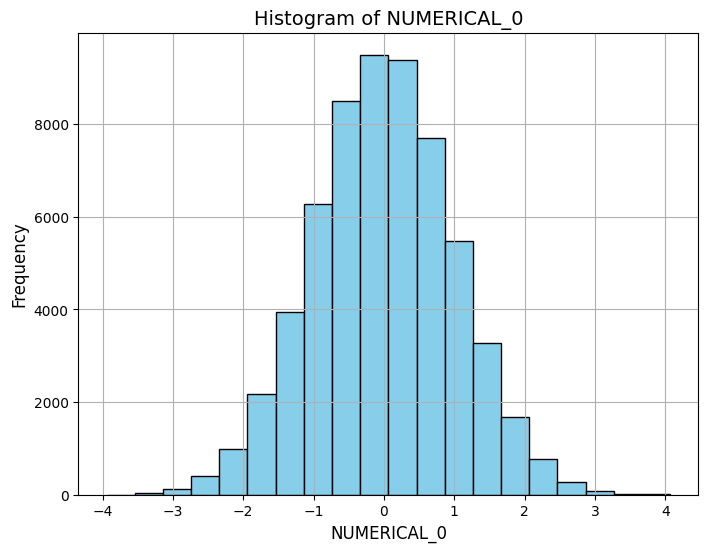

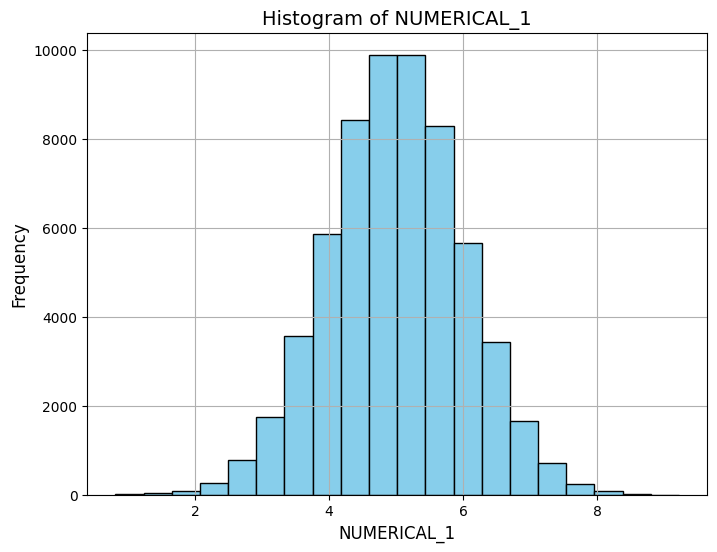

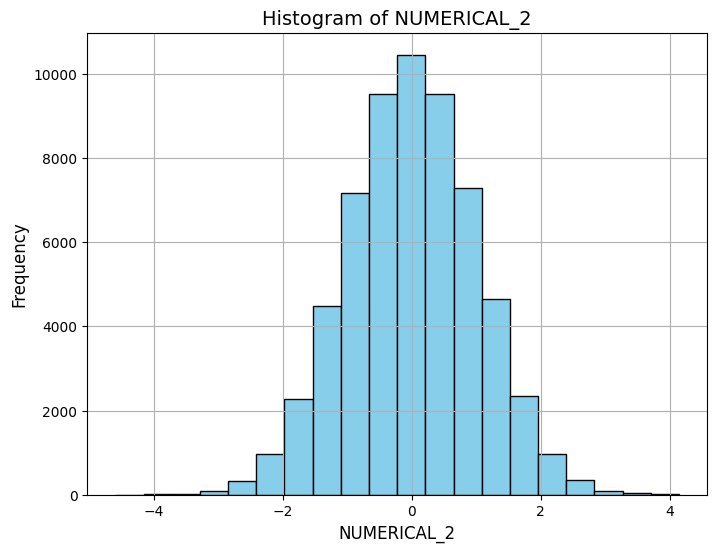

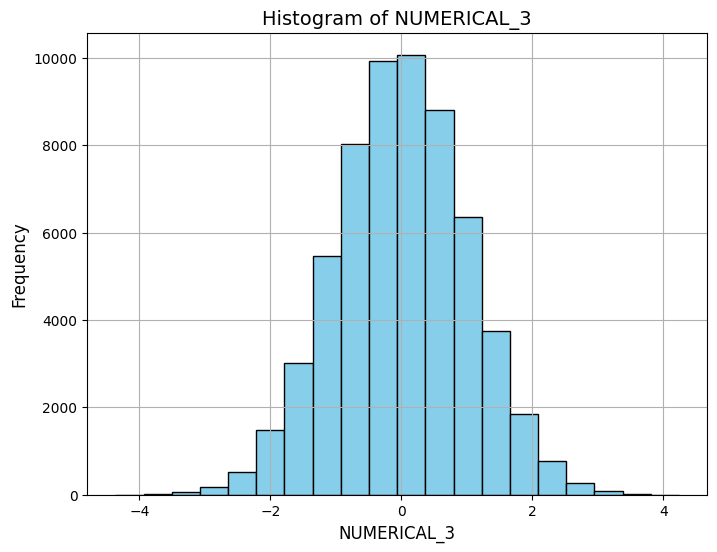

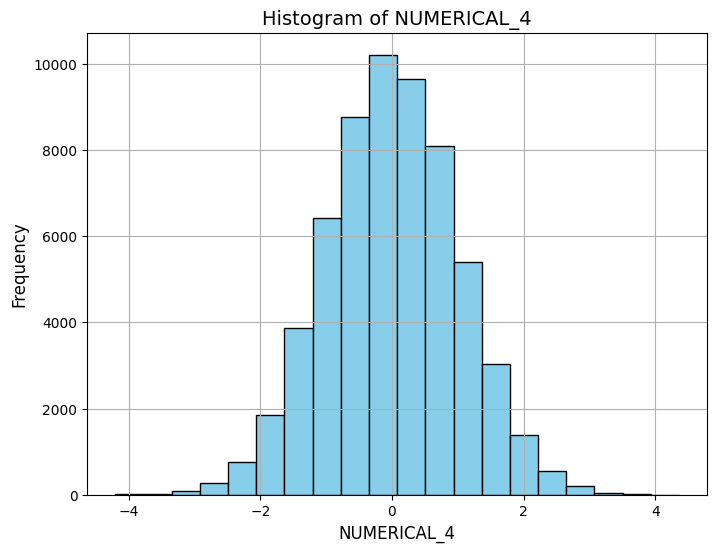

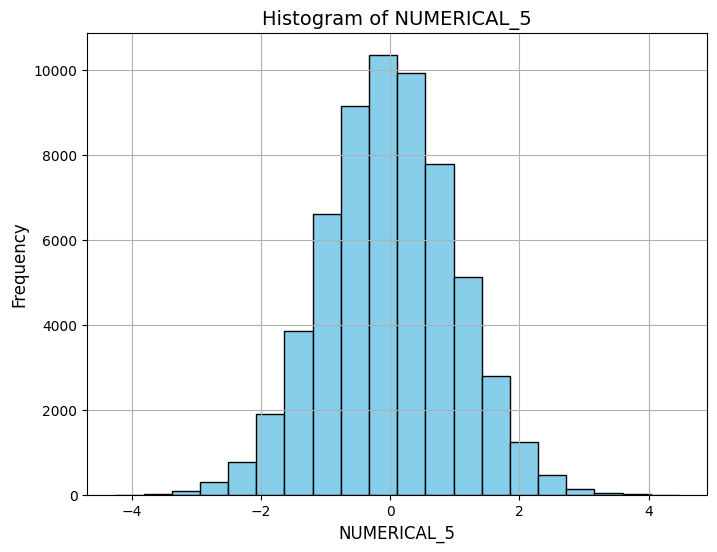

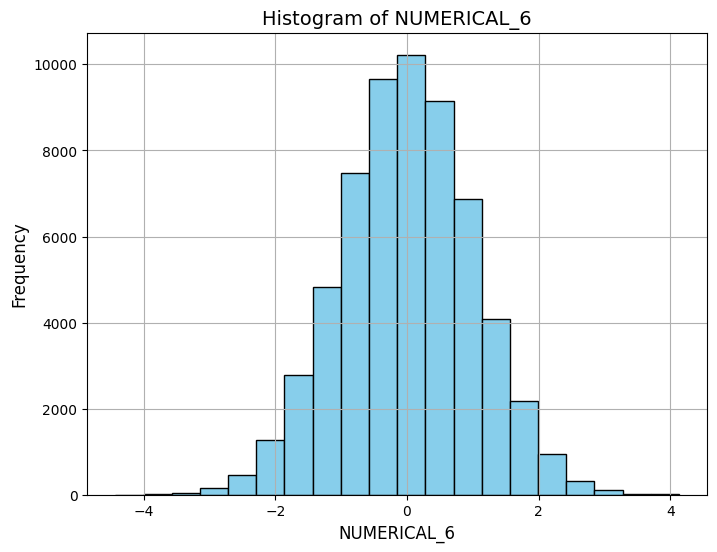

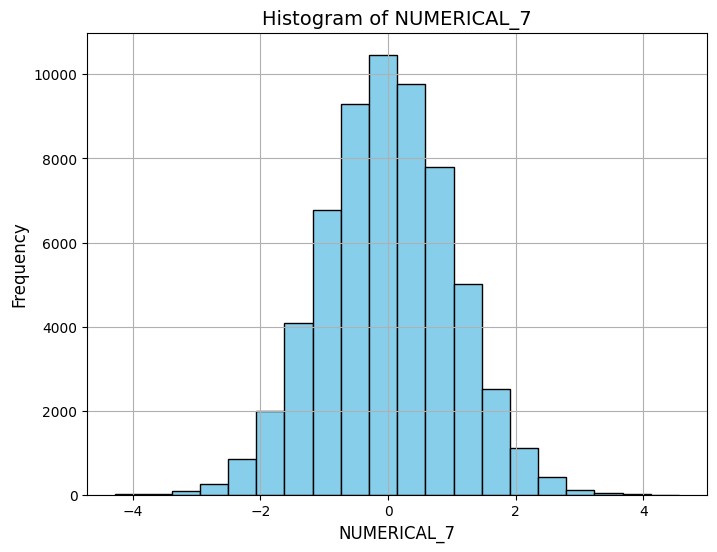

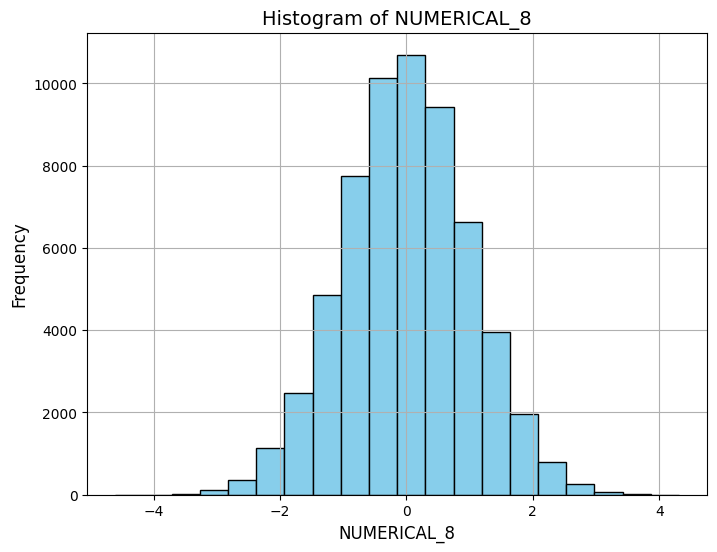

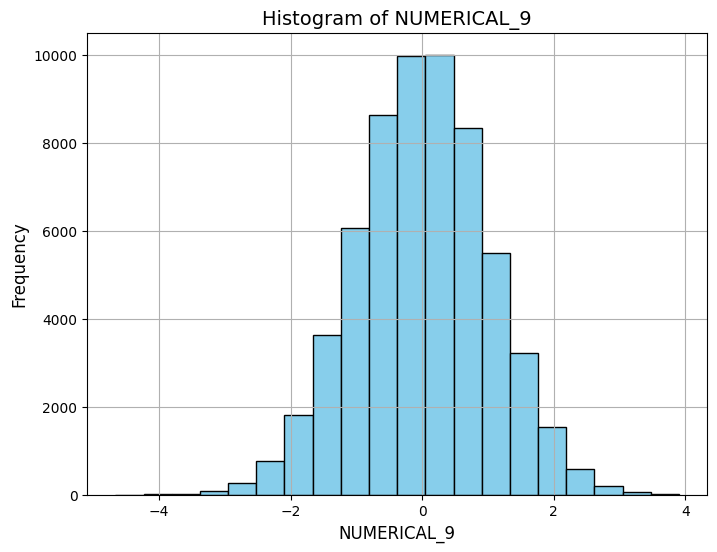

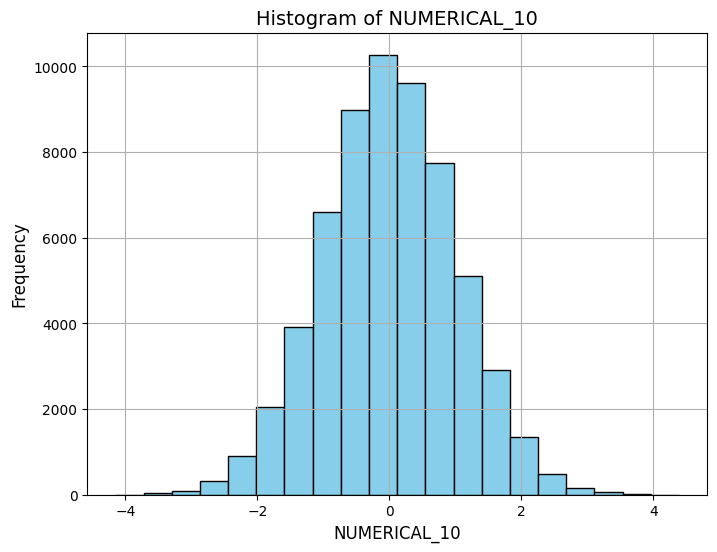

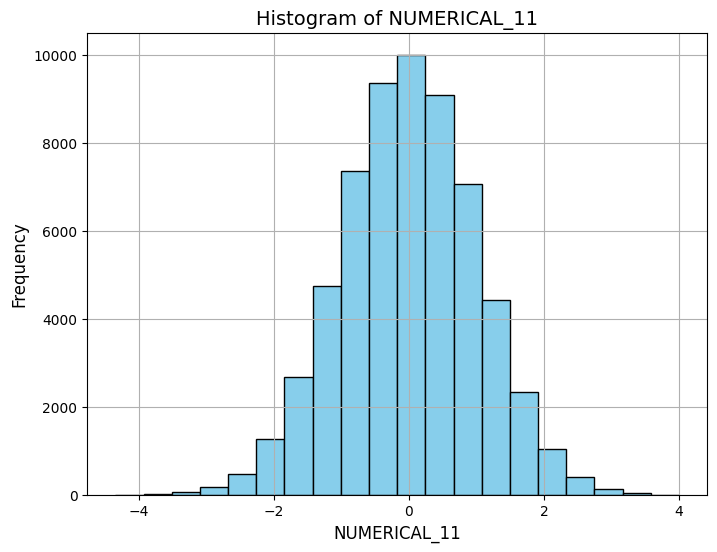

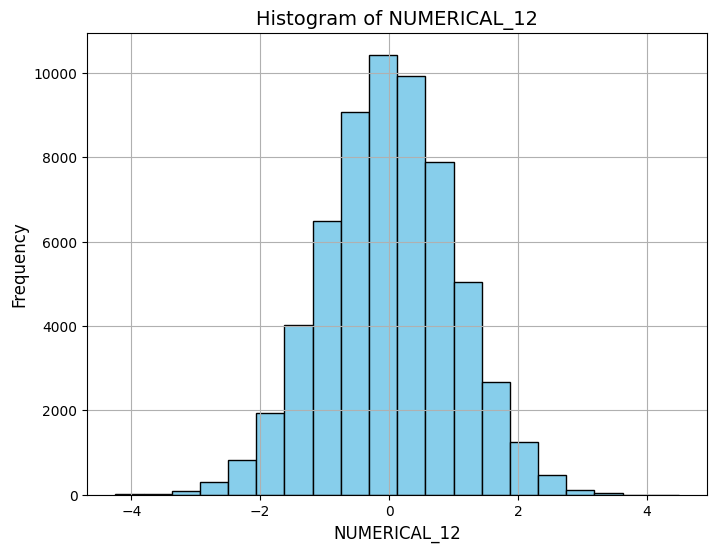

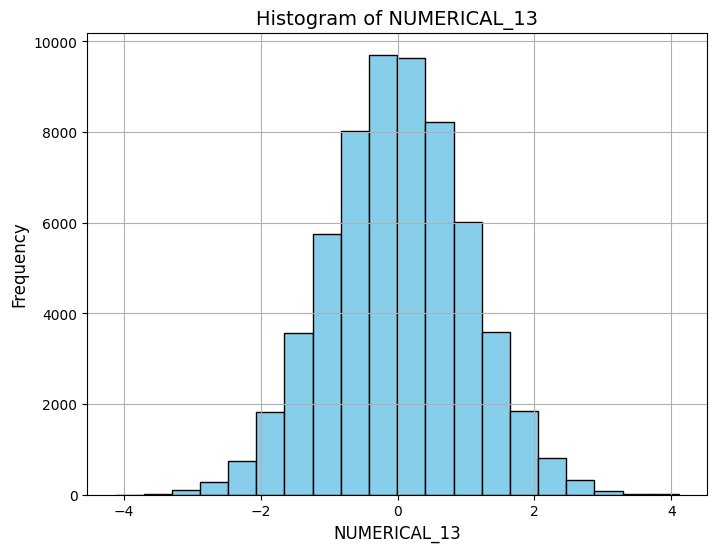

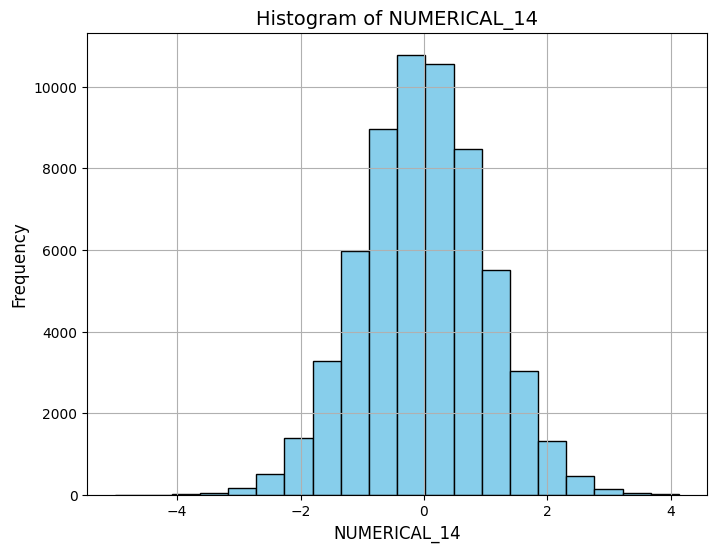

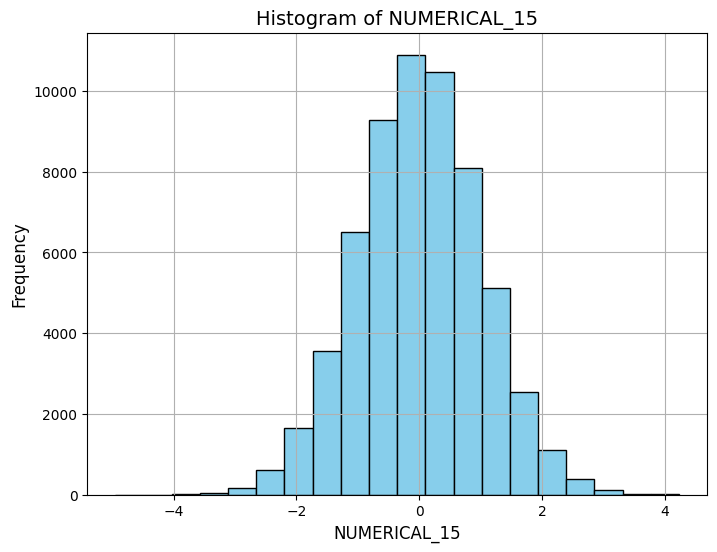

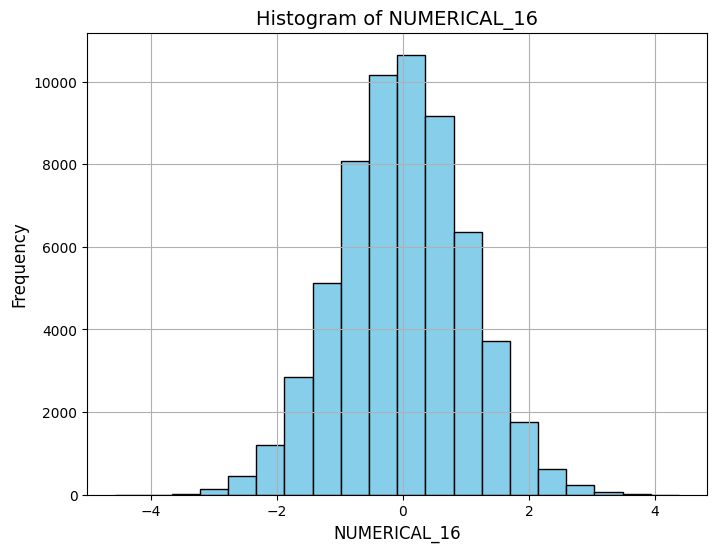

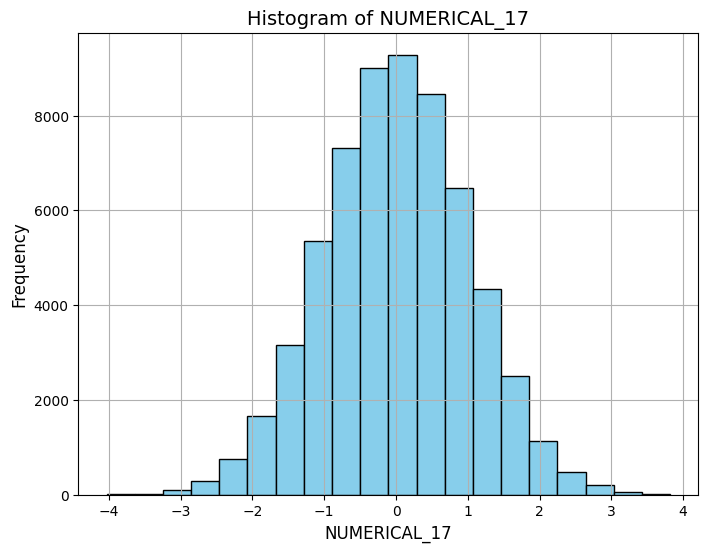

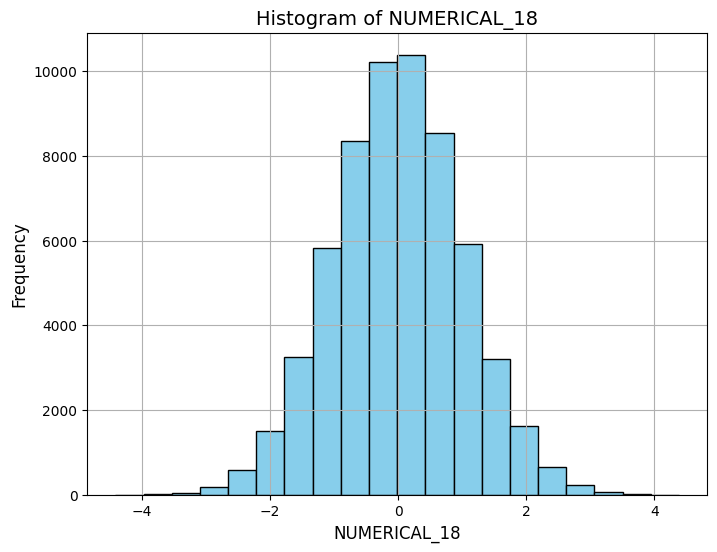

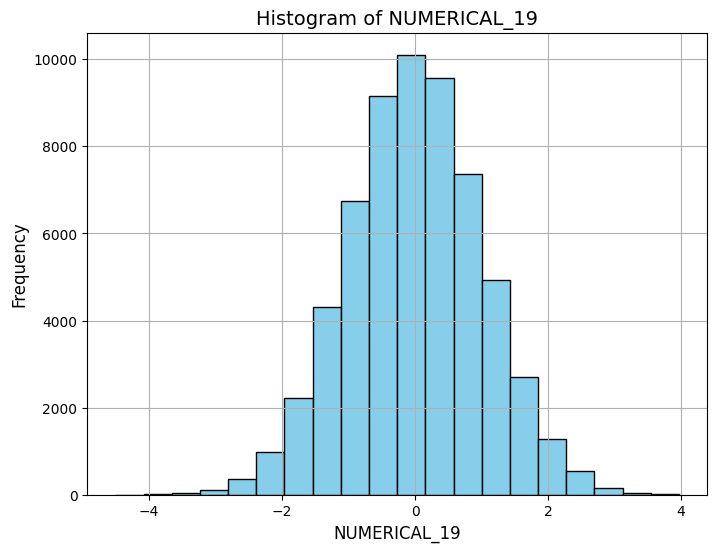

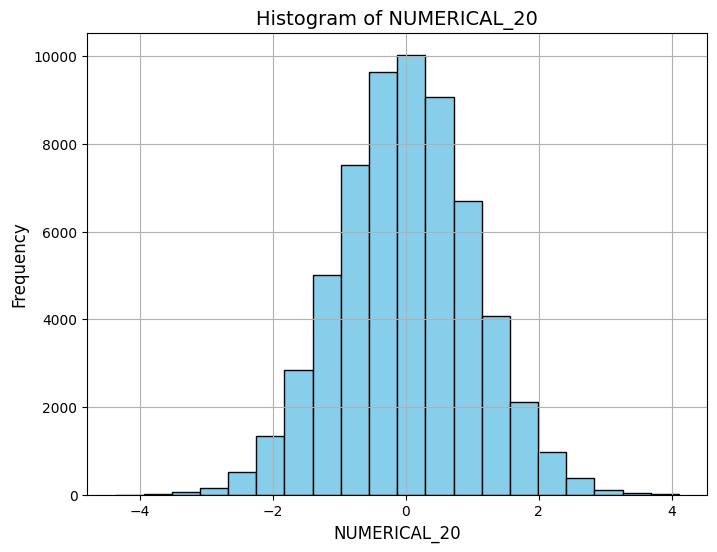

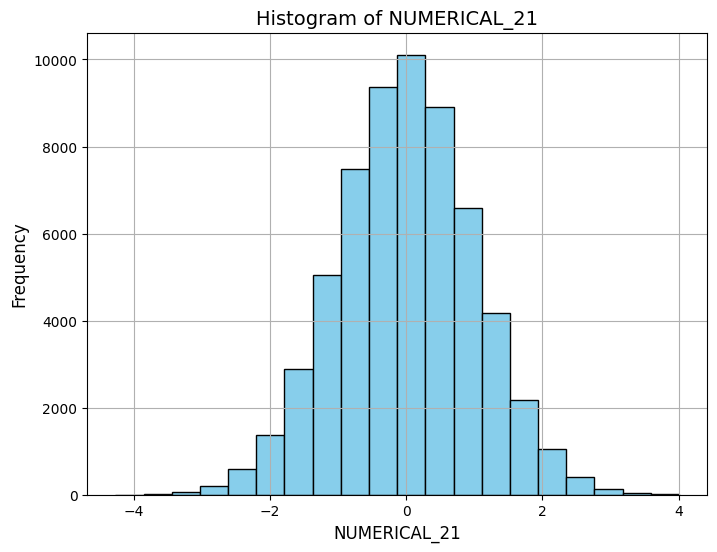

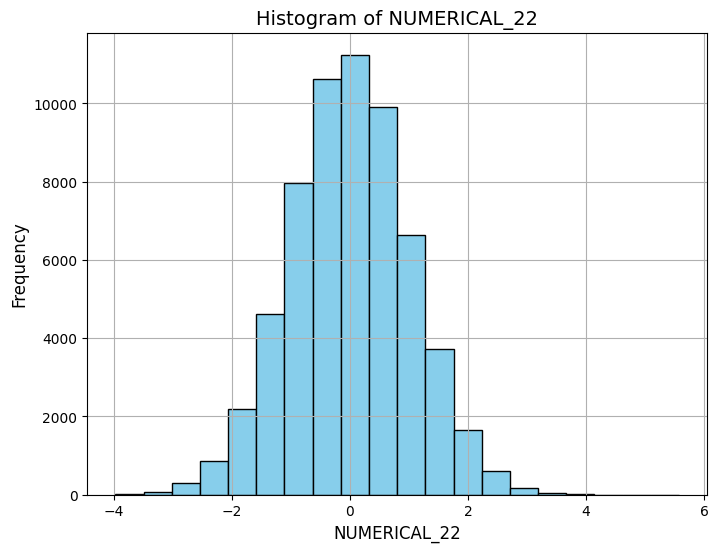

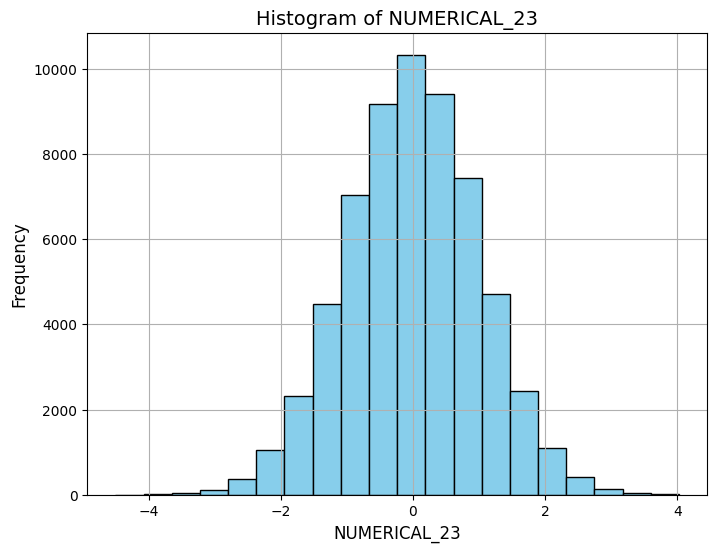

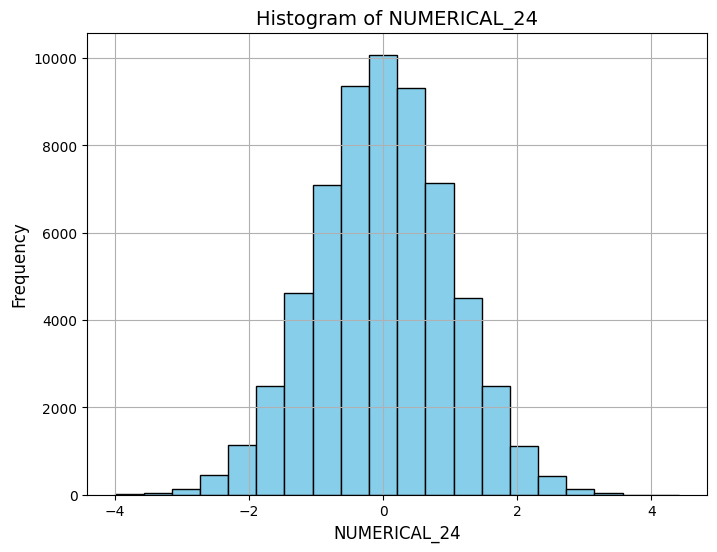

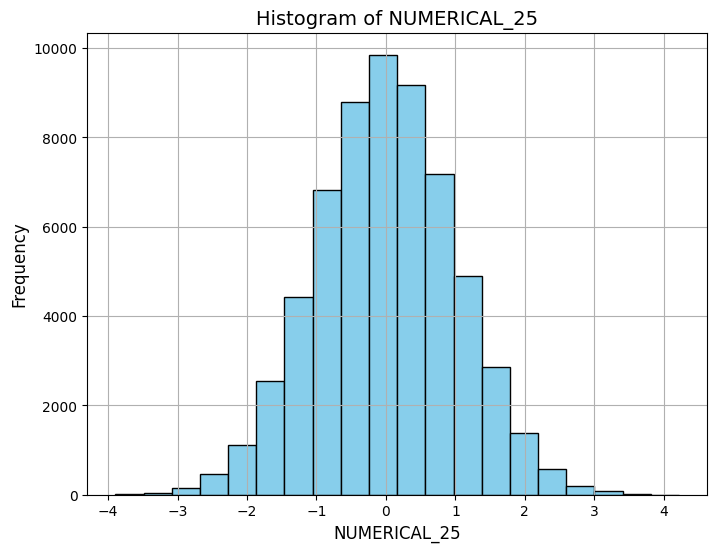

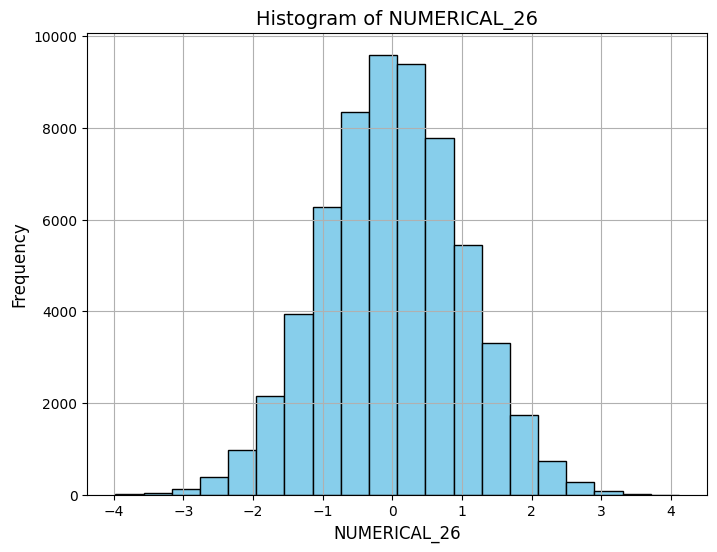

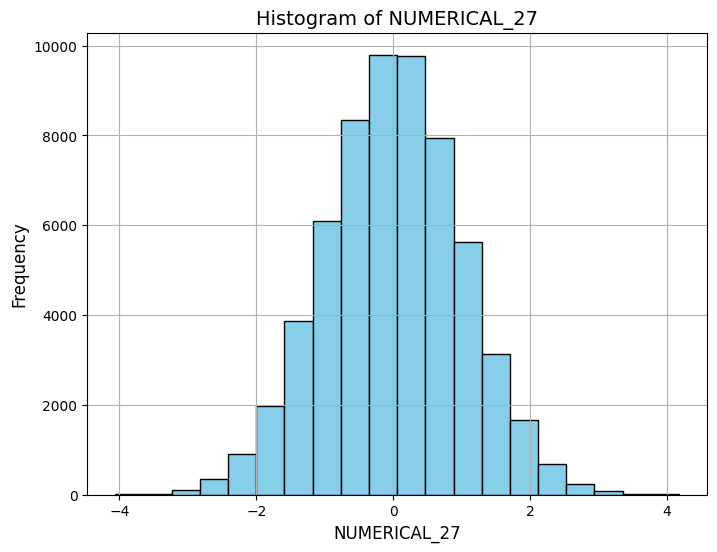

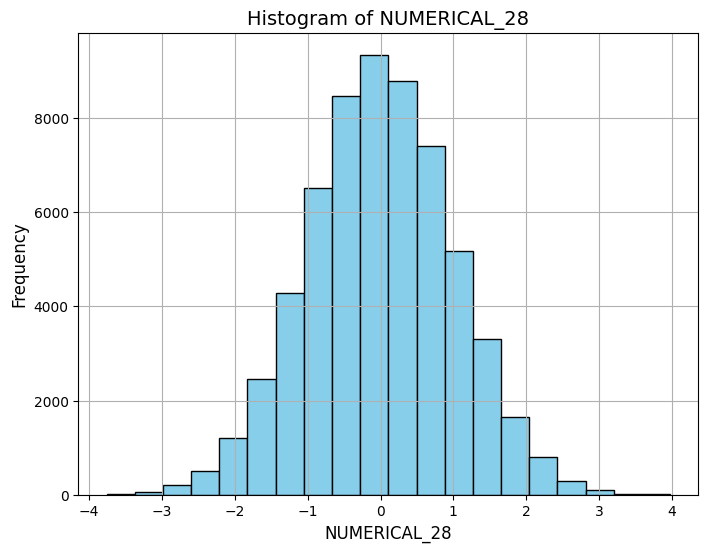

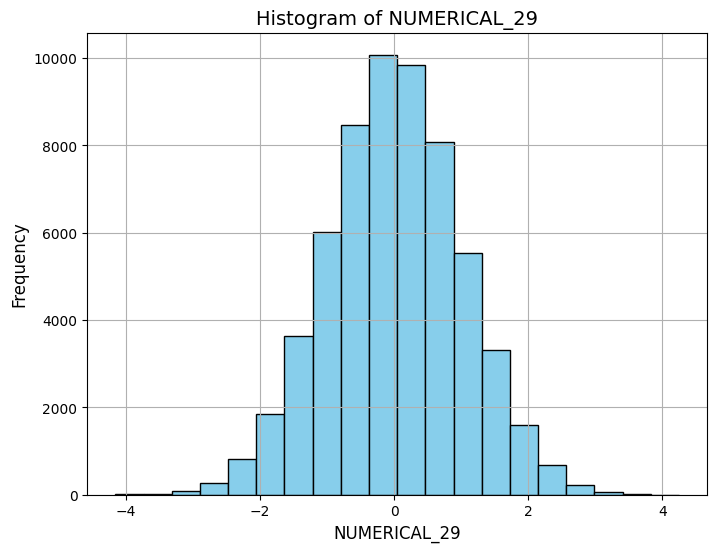

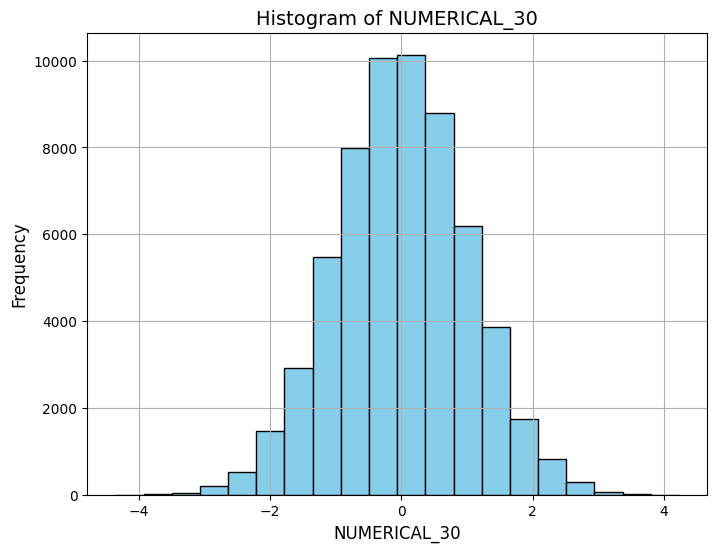

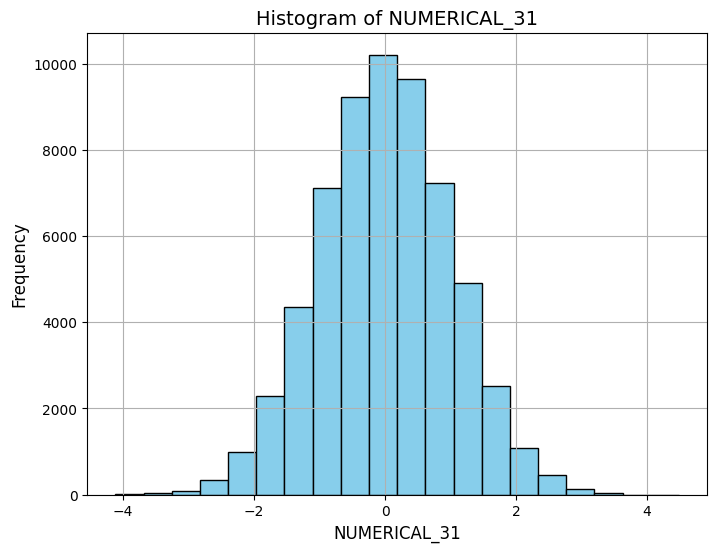

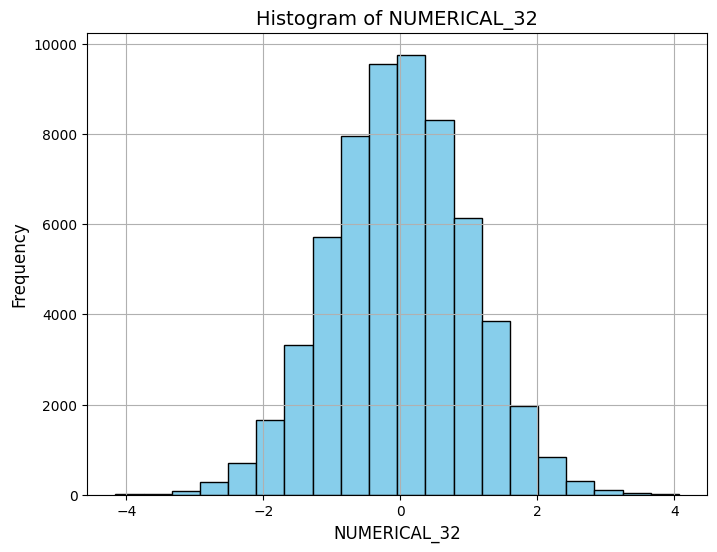

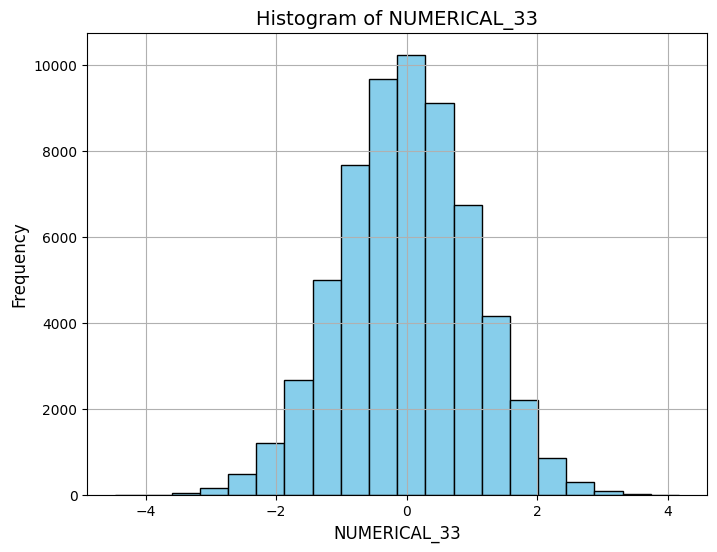

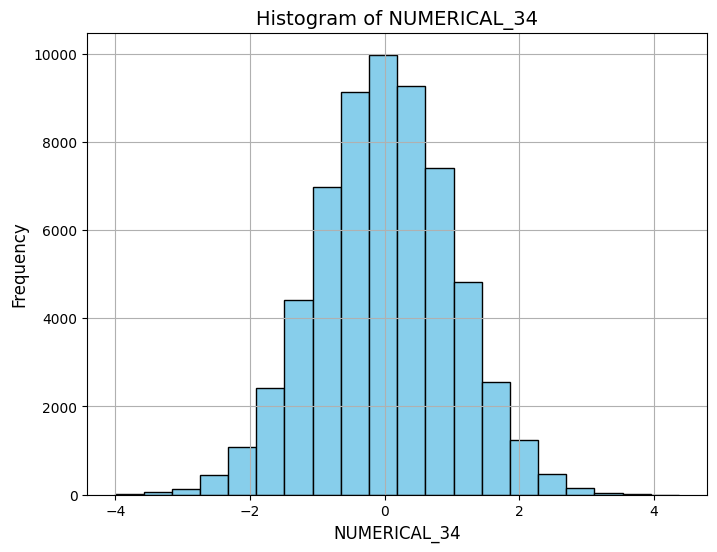

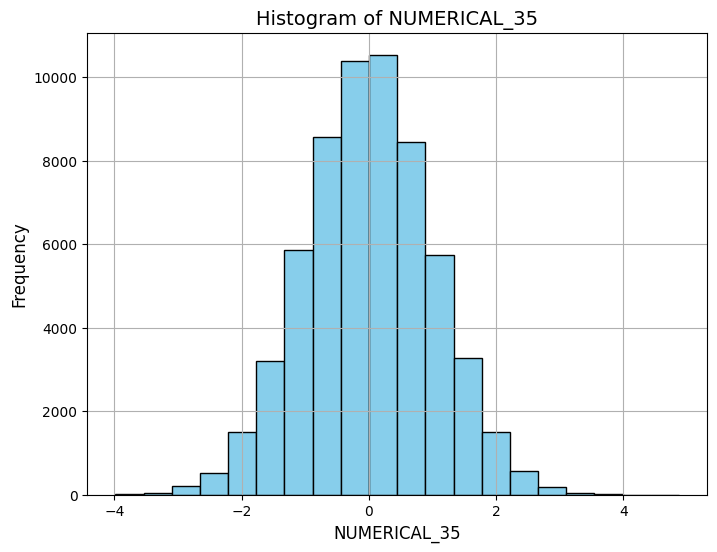

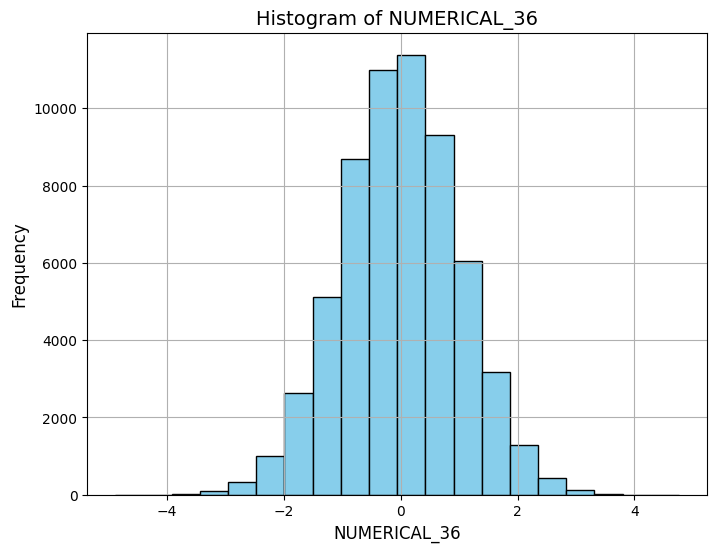

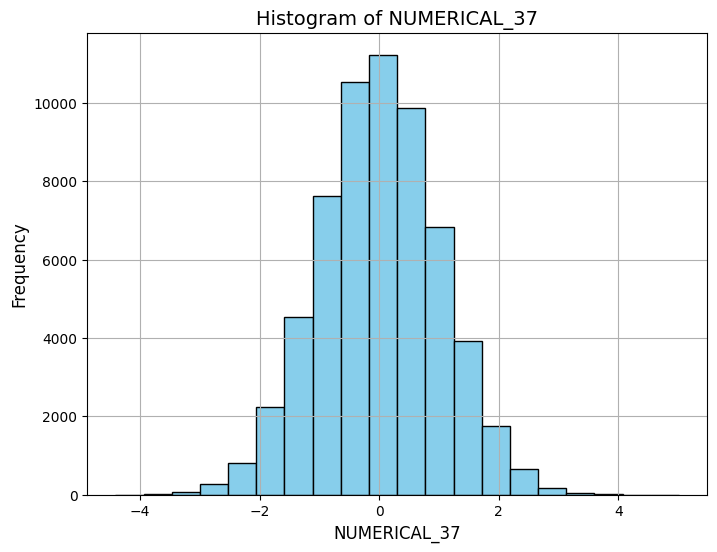

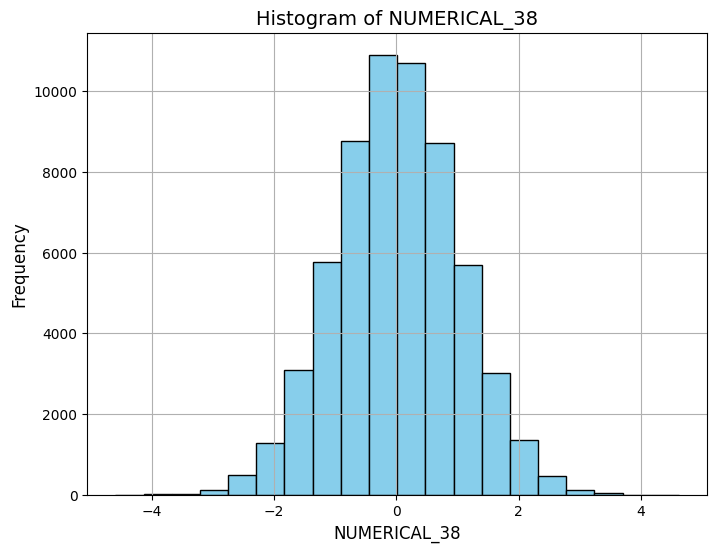

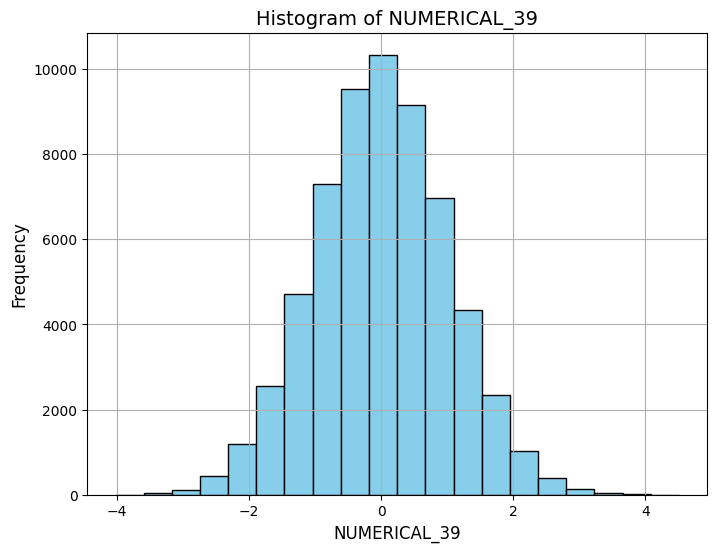

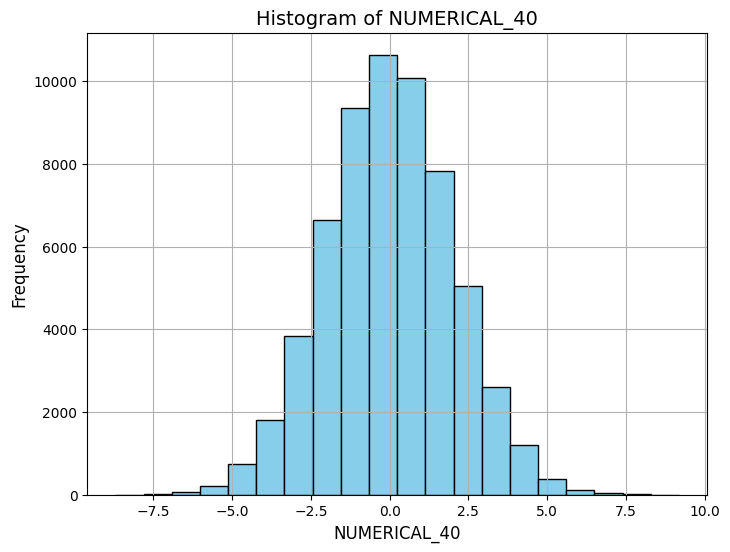

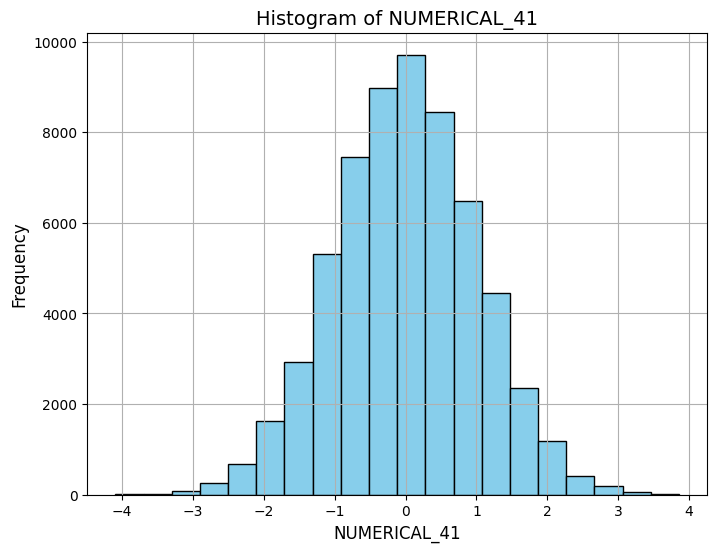

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_float_column_histograms(df):
    """
    Visualize histograms for float columns in the DataFrame.

    Parameters:
        df (pandas.DataFrame): Input DataFrame.

    Returns:
        None
    """
    # Select only float columns
    float_columns = df.select_dtypes(include=[float]).columns

    # Plot histograms for each float column
    for column in float_columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {column}', fontsize=14)
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True)
        plt.show()

# Visualize histograms for float columns
visualize_float_column_histograms(df=df)


In [34]:
pd.set_option('display.max_columns', None)
df.tail(100)

,ID_APPLICATION,TIME,NUMERICAL_0,NUMERICAL_1,NUMERICAL_2,NUMERICAL_3,NUMERICAL_4,NUMERICAL_5,NUMERICAL_6,NUMERICAL_7,NUMERICAL_8,NUMERICAL_9,NUMERICAL_10,NUMERICAL_11,NUMERICAL_12,NUMERICAL_13,NUMERICAL_14,NUMERICAL_15,NUMERICAL_16,NUMERICAL_17,NUMERICAL_18,NUMERICAL_19,NUMERICAL_20,NUMERICAL_21,NUMERICAL_22,NUMERICAL_23,NUMERICAL_24,NUMERICAL_25,NUMERICAL_26,NUMERICAL_27,NUMERICAL_28,NUMERICAL_29,NUMERICAL_30,NUMERICAL_31,NUMERICAL_32,NUMERICAL_33,NUMERICAL_34,NUMERICAL_35,NUMERICAL_36,NUMERICAL_37,NUMERICAL_38,NUMERICAL_39,NUMERICAL_40,NUMERICAL_41,TARGET,CATEGORICAL_0_FPTCW,CATEGORICAL_0_IMFRD,CATEGORICAL_0_JJUFY,CATEGORICAL_0_SUPSY,CATEGORICAL_0_UQPEF,CATEGORICAL_1_DVSOM,CATEGORICAL_1_FCOHQ,CATEGORICAL_1_OMFDE,CATEGORICAL_2_AA,CATEGORICAL_2_AB,CATEGORICAL_3_AS,CATEGORICAL_3_DF,CATEGORICAL_4_GH,CATEGORICAL_4_JK,CATEGORICAL_5_TR,CATEGORICAL_5_WE,CATEGORICAL_6_A,CATEGORICAL_6_B,CATEGORICAL_6_C,CATEGORICAL_7_A,CATEGORICAL_7_B,CATEGORICAL_7_C,CATEGORICAL_8_AA,CATEGORICAL_8_BB,CATEGORICAL_9_AA,CATEGORICAL_9_BB,CATEGORICAL_10_HNPAK,CATEGORICAL_10_NFAYV
199741,199741,2015-05-31 12:42:18,-0.475594,0.085265,0.989197,-0.364975,-0.211773,0.354817,0.618022,0.862126,0.488099,-1.571369,-0.281094,-0.633534,0.334323,-2.093550,-0.476579,-0.906606,0.088823,1.610582,-1.777060,0.059147,-0.216437,-0.610225,-0.701686,-0.120046,0.698931,-0.915037,-0.260696,-1.879840,1.118021,-0.491810,0.543337,0.014539,0.591978,0.400431,0.323124,1.579152,-1.049324,0.506202,0.612483,-0.817401,-0.611969,-0.502622,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,1
199746,199746,2015-05-31 12:52:46,0.052083,-1.673605,0.045267,0.133826,1.501685,-1.669284,-0.605839,1.429149,0.048472,-1.251161,-1.356167,1.247916,1.471193,0.746257,1.253127,1.331609,-0.629462,-1.711245,0.199690,-1.163434,0.173691,0.638571,-0.885797,0.592535,1.167837,0.163476,-0.886989,1.683824,-0.144254,0.086209,-0.246720,0.778150,-0.011843,1.590483,-1.844776,0.181889,-0.424880,1.256930,-1.422547,0.865905,-0.745810,-1.142135,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0
199747,199747,2015-05-31 12:57:35,-0.022618,0.160558,-1.351877,-2.959421,-0.481844,2.016591,2.875677,-0.468264,0.868914,-0.197312,-1.626632,2.324107,0.442447,-0.228510,-0.217205,-0.073472,-0.854770,-0.680636,0.944410,-0.746801,-0.114968,1.817500,0.985369,-0.645972,-1.641400,-1.336865,0.651222,0.312461,-0.372878,1.531731,0.875669,-0.977919,0.444873,-0.971174,0.053527,0.235977,-1.055633,-0.029731,-1.050020,0.781901,-0.103819,-1.675338,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,1,0,1,0
199748,199748,2015-05-31 13:00:28,0.613745,-1.015290,0.473141,-0.458374,0.782612,-1.877546,0.575873,-1.015617,-1.106173,0.512825,-0.858615,-1.357715,-1.625121,-0.633640,0.534532,-0.170712,0.583277,0.452373,0.784335,0.984589,-0.050512,0.063345,-1.341597,1.009327,-1.180452,0.124813,-1.995987,-0.518921,-1.101842,-1.064465,-0.347751,-0.164204,-0.506675,-0.992097,2.680765,-1.415583,-1.102056,0.147231,0.969896,-0.618825,0.032559,-0.362763,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,0,1
199751,199751,2015-05-31 13:04:27,-1.711519,-1.180818,-0.824958,-0.133538,0.046974,0.638035,-1.827452,1.192175,-0.352015,0.352168,-1.031382,-0.275110,-0.212619,0.369655,0.194904,0.373538,-0.131178,0.880405,-0.077024,-0.089298,-1.693614,-0.332047,-0.184803,0.312959,1.795063,0.621324,-0.426498,1.193538,-0.076540,-1.390803,-0.224944,1.026336,0.140025,-0.195084,-0.119605,-2.190821,-1.523085,-0.746480,-0.650018,0.360711,-0.781589,-1.042843,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199988,199988,2015-05-31 22:53:35,-1.079608,-1.029035,-0.513399,0.734580,0.178972,3.379386,-0.030374,2.036158,0.545932,0.370281,1.188792,0.372056,0.017757,0.971335,-0.4477

In [35]:
df.shape

(60624, 73)

In [80]:
# Iterate over each column and check for NaN values
nan_values = {col: df[col].isna().any() for col in df.columns}

# Filter columns with True values (NaN values)
true_columns = {col: value for col, value in nan_values.items() if value}

print(true_columns)

{}


In [ ]:
    def choose_classification_algorithm(self, X, y, cv=5):
        """
        Choose a suitable classification algorithm for the given task.
    
        Parameters:
        X (pandas.DataFrame): Input DataFrame containing features.
        y (pandas.Series): Target variable.
        cv (int): Number of folds in cross-validation.
    
        Returns:
        str: Name of the selected classification algorithm.
        """
        algorithms = {
            "Logistic Regression": LogisticRegression(),
            # "Decision Tree": DecisionTreeClassifier(),
            # "Random Forest": RandomForestClassifier(),
            # "Support Vector Machine": SVC(),
            # "K-Nearest Neighbors": KNeighborsClassifier()
        }
    
        results = {}
        for name, model in algorithms.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            results[name] = np.mean(scores)
    
        # Select the algorithm with the highest mean accuracy
        best_algorithm = max(results, key=results.get)
        
        # Log the results
        logging.info("Cross-validation results:")
        for name, score in results.items():
            logging.info("%s: Mean Accuracy = %.4f", name, score)
    
        logging.info("Selected algorithm: %s", best_algorithm)
    
        return best_algorithm

In [52]:
import sys
!{sys.executable} -m pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 603.9 kB/s eta 0:00:0000:0100:01


## BACK UP

In [ ]:
    
    def detect_outliers(self, df, threshold=3, visualize=False):
        """
        Detect outliers in numerical columns of the dataset using the Z-score method.
    
        Parameters:
        df (pandas.DataFrame): Input DataFrame.
        threshold (float): Threshold value for outlier detection. Default is 3.
        visualize (bool): Whether to visualize the distribution of data for each column. Default is False.
    
        Returns:
        list: List of indices corresponding to the rows containing outliers.
        """
        outliers_indices = []
    
        # Select only numerical columns
        numerical_columns = df.select_dtypes(include=[np.number]).columns
        
        # Calculate the number of rows and columns for subplots
        num_plots = len(numerical_columns)
        num_cols = min(num_plots, 5)
        num_rows = (num_plots + num_cols - 1) // num_cols
        
        # Create subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
        
        # Flatten axes if needed
        axes = axes.flatten()
        
        # Iterate over numerical columns in the DataFrame
        for i, column in enumerate(numerical_columns):
            # Calculate Z-score for each value in the column
            z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
            
            # Find indices of outliers based on threshold
            column_outliers_indices = z_scores[z_scores > threshold].index
            
            # Extend outliers_indices list with column_outliers_indices
            outliers_indices.extend(column_outliers_indices)
            
            # Visualize box plot if visualize is True
            if visualize:
                sns.boxplot(x=df[column], ax=axes[i])
                axes[i].set_title(f'Box plot of {column}')
                axes[i].set_xlabel(column)
        
        # Remove duplicate indices
        outliers_indices = list(set(outliers_indices))
        
        # Log the number of outliers detected
        logging.info("Number of outliers detected: %d", len(outliers_indices))
        
        # Show plot if visualize is True
        if visualize:
            plt.tight_layout()
            plt.show()
        
        return outliers_indices
    
    
    # def detect_outliers(self, df, threshold=3, visualize=False):
    #     """
    #     Detect outliers in numerical columns of the dataset using the Z-score method.
    
    #     Parameters:
    #     df (pandas.DataFrame): Input DataFrame.
    #     threshold (float): Threshold value for outlier detection. Default is 3.
    #     visualize (bool): Whether to visualize the distribution of data for each column. Default is False.
    
    #     Returns:
    #     list: List of indices corresponding to the rows containing outliers.
    #     """
    #     outliers_indices = []
    
    #     # Select only numerical columns
    #     numerical_columns = df.select_dtypes(include=[np.number]).columns
        
    #     # Iterate over numerical columns in the DataFrame
    #     for column in numerical_columns:
    #         # Calculate Z-score for each value in the column
    #         z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
            
    #         # Find indices of outliers based on threshold
    #         column_outliers_indices = z_scores[z_scores > threshold].index
            
    #         # Extend outliers_indices list with column_outliers_indices
    #         outliers_indices.extend(column_outliers_indices)
            
    #         # Visualize distribution of data if visualize is True
    #         if visualize:
    #             plt.figure(figsize=(8, 6))
    #             sns.histplot(df[column], kde=True)
    #             plt.title(f'Distribution of {column}')
    #             plt.xlabel(column)
    #             plt.ylabel('Frequency')
    #             plt.show()
        
    #     # Remove duplicate indices
    #     outliers_indices = list(set(outliers_indices))
        
    #     # Log the number of outliers detected
    #     logging.info("Number of outliers detected: %d", len(outliers_indices))
        
    #     return outliers_indices

In [ ]:
    def choose_classification_algorithm(self, X, y, cv=5, file_path='results.txt'):
        """
        Choose a suitable classification algorithm for the given task and store results to a text file.
    
        Parameters:
        X (pandas.DataFrame): Input DataFrame containing features.
        y (pandas.Series): Target variable.
        cv (int): Number of folds in cross-validation.
        file_path (str): Path to the text file. Default is 'results.txt'.
    
        Returns:
        None
        """
        algorithms = {
            "Logistic Regression": LogisticRegression(),
            #"Decision Tree": DecisionTreeClassifier(),
            #"Random Forest": RandomForestClassifier(),
            #"Support Vector Machine": SVC(),
            #"K-Nearest Neighbors": KNeighborsClassifier()
        }
    
        with open(file_path, 'a') as file:
            for name, model in algorithms.items():
                # Perform cross-validation predictions
                y_pred = cross_val_predict(model, X, y, cv=cv)
                
                # Calculate evaluation metrics
                accuracy = accuracy_score(y, y_pred)
                precision = precision_score(y, y_pred)
                recall = recall_score(y, y_pred)
                f1 = f1_score(y, y_pred)
                
                # Write evaluation metrics and algorithm name to the text file
                file.write(f"Algorithm: {name}\n")
                file.write(f"Accuracy: {accuracy:.4f}\n")
                file.write(f"Precision: {precision:.4f}\n")
                file.write(f"Recall: {recall:.4f}\n")
                file.write(f"F1-score: {f1:.4f}\n")
                file.write("-" * 50 + "\n")
                
                # Print evaluation metrics
                logging.info("Evaluation metrics for %s:", name)
                logging.info("Accuracy: %.4f", accuracy)
                logging.info("Precision: %.4f", precision)
                logging.info("Recall: %.4f", recall)
                logging.info("F1-score: %.4f", f1)
                logging.info("-" * 50)

In [ ]:
    def setup_logging_to_file(self):
        """Set up logging configuration to output to both console and a log file."""
        log_file = 'log.txt'
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file, mode='a'),  # Append mode
                logging.StreamHandler()
            ]
        )

In [ ]:
    def choose_classification_algorithm(self, X, y, cv=5, file_path='results.txt'):
        """
        Choose a suitable classification algorithm for the given task and store results to a text file.
    
        Parameters:
        X (pandas.DataFrame): Input DataFrame containing features.
        y (pandas.Series): Target variable.
        cv (int): Number of folds in cross-validation.
        file_path (str): Path to the text file. Default is 'results.txt'.
    
        Returns:
        None
        """
        algorithms = {
            # "Logistic Regression": LogisticRegression(),
            # "Random Forest": RandomForestClassifier(),
            "XGBoost": xgb.XGBClassifier(),
            # "Support Vector Machine": SVC(),
        }
    
        with open(file_path, 'a') as file:
            for name, model in algorithms.items():
                # Perform cross-validation predictions
                y_pred = cross_val_predict(model, X, y, cv=cv)
                
                # Calculate evaluation metrics
                accuracy = accuracy_score(y, y_pred)
                precision = precision_score(y, y_pred)
                recall = recall_score(y, y_pred)
                f1 = f1_score(y, y_pred)
                
                # Write evaluation metrics and algorithm name to the text file
                file.write(f"Algorithm: {name}\n")
                file.write(f"Accuracy: {accuracy:.4f}\n")
                file.write(f"Precision: {precision:.4f}\n")
                file.write(f"Recall: {recall:.4f}\n")
                file.write(f"F1-score: {f1:.4f}\n")
                file.write("-" * 50 + "\n")
                
                # Print evaluation metrics
                logging.info("Evaluation metrics for %s:", name)
                logging.info("Accuracy: %.4f", accuracy)
                logging.info("Precision: %.4f", precision)
                logging.info("Recall: %.4f", recall)
                logging.info("F1-score: %.4f", f1)
                logging.info("-" * 50)


In [ ]:
# Evaluate the predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Evaluation metrics on the test set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# You can also print a confusion matrix for more detailed analysis
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
    def tune_hyperparameters(self, X_train, y_train):
        """
        Tune hyperparameters using RandomizedSearchCV for the XGBoost classifier.

        Parameters:
            X_train (pandas.DataFrame): Training features.
            y_train (pandas.Series): Training labels.

        Returns:
            dict: Best hyperparameters found during the search.
            sklearn.base.BaseEstimator: Best model trained with the best hyperparameters.
        """
        # Define the hyperparameter search space
        param_dist = {
            'learning_rate': [0.01, 0.1],
            'max_depth': range(3, 10),
            'min_child_weight': range(1, 10),
            'gamma': [0, 1, 5]
        }

        # Create the XGBoost classifier model
        model = xgb.XGBClassifier()

        # Define the RandomizedSearchCV object
        random_search = RandomizedSearchCV(estimator=model,
                                           param_distributions=param_dist,
                                           n_iter=100,  # Number of random parameter sets to try
                                           scoring="roc_auc",  # Evaluation metric (e.g., AUC-ROC)
                                           cv=5)  # Number of cross-validation folds

        # Fit the model with randomized search
        random_search.fit(X_train, y_train)

        # Access the best hyperparameters
        best_params = random_search.best_params_

        # Access the best model
        best_model = random_search.best_estimator_

        # Print the best hyperparameters
        print("Best Hyperparameters:", best_params)

        return best_params, best_model

# Best Hyperparameters: {'min_child_weight': 9, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0}